In [8]:
%load_ext autoreload
%autoreload 2

from itertools import product
from dataclasses import dataclass
import os
import math
import sys
from typing import Dict, Any, List, Optional
sys.path.append('../../../../')

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import numpy as np
import pandas as pd

from matplotlib.ticker import FuncFormatter

from multitask_nlp.utils.plotting import Task, get_overall_score, visualize_boxplot

color_pallette = 'muted'
sns.set_theme(style='whitegrid', context='talk', palette=color_pallette, 
              rc={'font.family': 'serif', 'font.serif': 'Times New Roman', 'mathtext.fontset': 'dejavuserif'})

tasks = [
    Task(name='BoolQ', measure='macro_f1_label', 
         measure_name='Macro F1', size=6927),
    Task(name='CommitmentBank', short_name='CB', measure='macro_f1_label', 
         measure_name='Macro F1', size=200),
    Task(name='GoEmotions', short_name='GoEmo', measure='macro_f1_mean', 
         measure_name='Macro F1', size=34806),
    Task(name='MeasuringHateSpeech', short_name='MHS', measure='r2_hate_speech_score', 
         measure_name='R2', size=23739),
    Task(name='Multiemo', measure='macro_f1_sentiment', 
         measure_name='Macro F1', size=6572),
    Task(name='MultiRC', measure='macro_f1_label', 
         measure_name='Macro F1', size=22275),
    Task(name='Pejorative', measure='macro_f1_is_pejorative', 
         measure_name='Macro F1', size=638),
    Task(name='RTE', measure='macro_f1_label', 
         measure_name='Macro F1', size=2190),
    Task(name='SciTail', measure='macro_f1_label', 
         measure_name='Macro F1', size=23097),
    Task(name='SST-2', measure='macro_f1_label', 
         measure_name='Macro F1', size=66449),
    Task(name='STS-B', measure='r2_label', 
         measure_name='R2', size=4249)  
]


cols_to_display = ['dataset', 'learning_kind', 'model_name', 'model_type',
       'mt_dataset_type',  'scale_class_loss', 'type', 'overall_score', 'weighted_overall_score']


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
def get_type(row):
    ttype = row['learning_kind']
    if not pd.isna(row['mt_dataset_type']):
        ttype += '_' + str(row['mt_dataset_type'])
        if row['mt_dataset_type'] == 'proportional_sampling':
            ttype += r'_$\alpha={}$'.format(row['alpha'])
        
    return ttype

def load_results_df(file_path: str):
    df = pd.read_csv(file_path)
    df['type'] = df.apply(lambda x: get_type(x), axis=1)
    df['overall_score'] = df.apply(lambda x: get_overall_score(x, tasks=tasks), axis=1)
    df['weighted_overall_score'] = df.apply(lambda x: get_overall_score(x, tasks=tasks, weighted=True), axis=1)
    
    for scale_class_loss, model_name in product(df['scale_class_loss'].unique(), df['model_name'].unique()):
        curr_df = df[(df['learning_kind'] == 'STL') & (df['scale_class_loss'] == scale_class_loss)
                     & (df['model_name'] == model_name)]
        
        stl_results = {}
        for task_name in curr_df.dataset.unique():
            for task in tasks:
                if task_name == task.name:
                    col_measure = f'{task.name}_test_{task.measure}'
                    stl_results[task.name] = curr_df[curr_df.dataset == task.name][col_measure].values, task.size

        total_size = sum([task.size for task in tasks])
        overall_results = sum([v[0] for v in stl_results.values()]) / len(tasks)
        weighted_overall_results = sum([v[1]*v[0] for v in stl_results.values()]) / total_size

        records = [
            {'type': 'STL', 
             'scale_class_loss': scale_class_loss, 
             'model_name': model_name,
             'overall_score': r1, 
             'weighted_overall_score': r2}
            for r1, r2 in zip(overall_results, weighted_overall_results)
        ]
        df = pd.concat([df, pd.DataFrame(records)], ignore_index=True) 

    return df

In [10]:
df = load_results_df('mtl_bert_vs_xtremed_results.csv')
df['model_kind'] = df.apply(lambda r: r['model_name'] + ' ' + r['scale_class_loss'], axis=1)

In [11]:
# with pd.option_context('display.max_rows', None):
#     display(df[cols_to_display])

In [12]:
# with pd.option_context('display.max_rows', None):
#     display(df[['dataset', 'type', 'BoolQ_test_macro_f1_label', 'overall_score']])

In [13]:
# with pd.option_context('display.max_rows', None):
#     display(df[['dataset', 'type', 'scale_class_loss', 'epoch', 'num_epochs', 'trainer/global_step', 'Runtime']])

In [14]:
# df.columns.values

In [15]:
df['model_kind'].unique()

array(['bert log', 'bert linear', 'bert none', 'xtremedistil-l6-h256 log',
       'xtremedistil-l6-h256 linear', 'xtremedistil-l6-h256 none'],
      dtype=object)

In [16]:
df['type'].unique()

array(['MTL_annealing_sampling',
       'MTL_proportional_sampling_$\\alpha=0.75$', 'MTL_sampling',
       'MTL_round_robin', 'STL'], dtype=object)

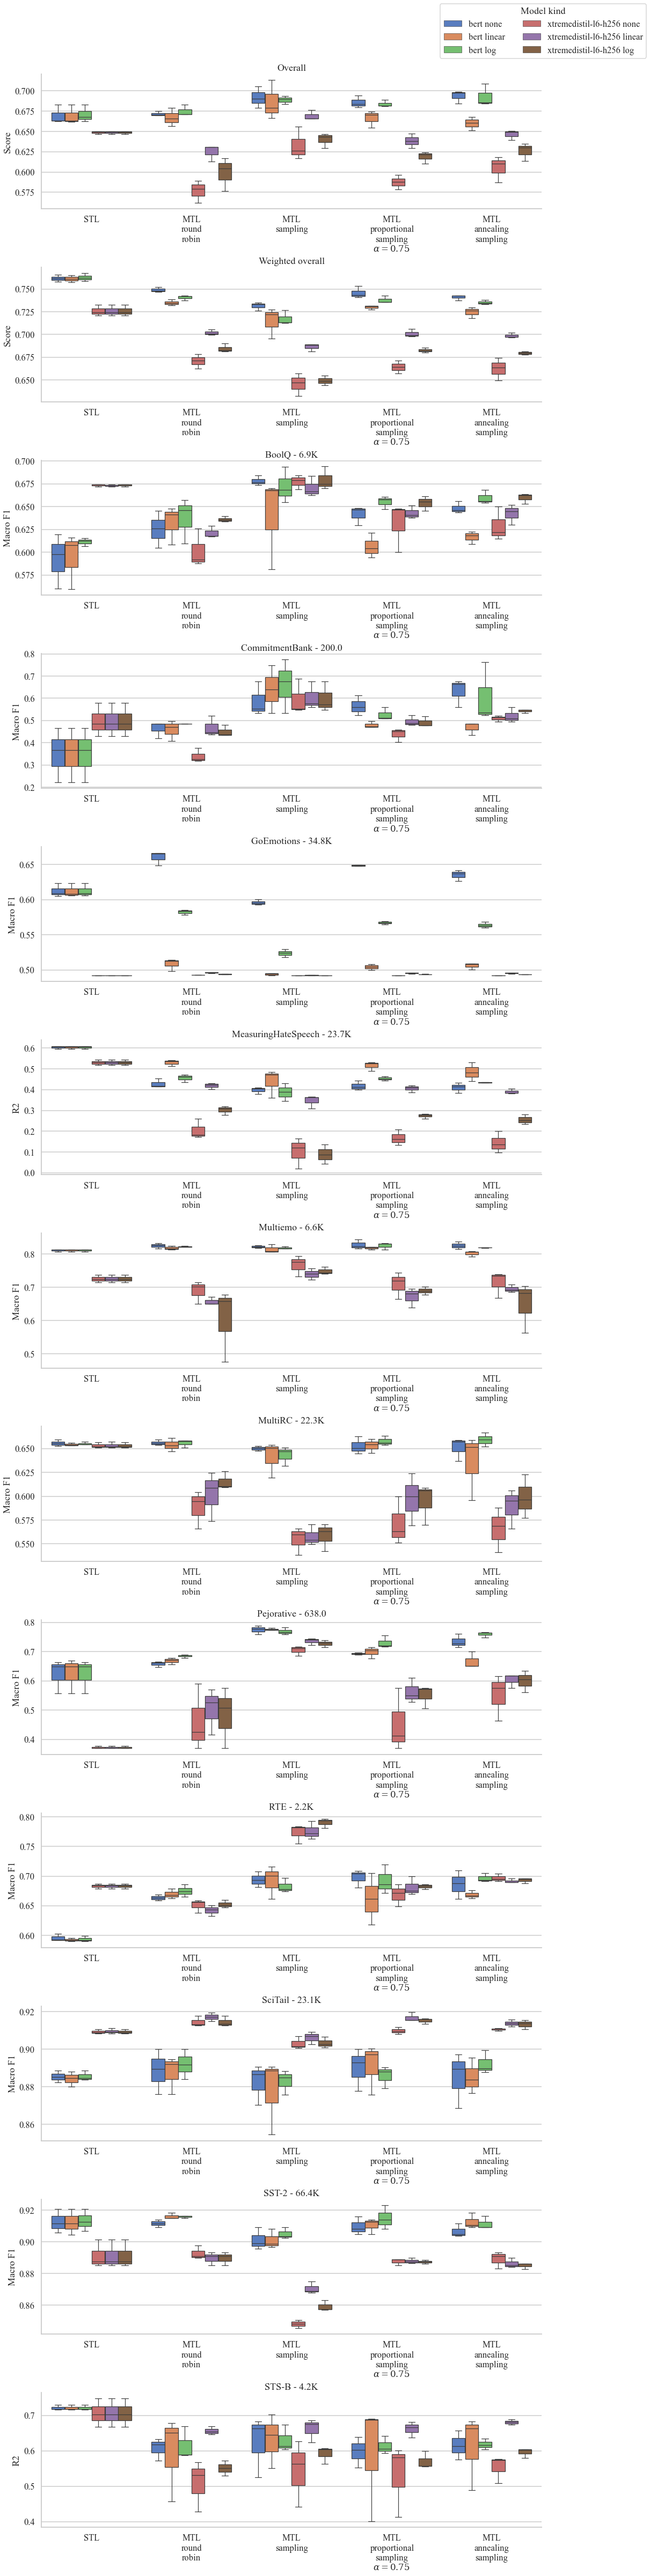

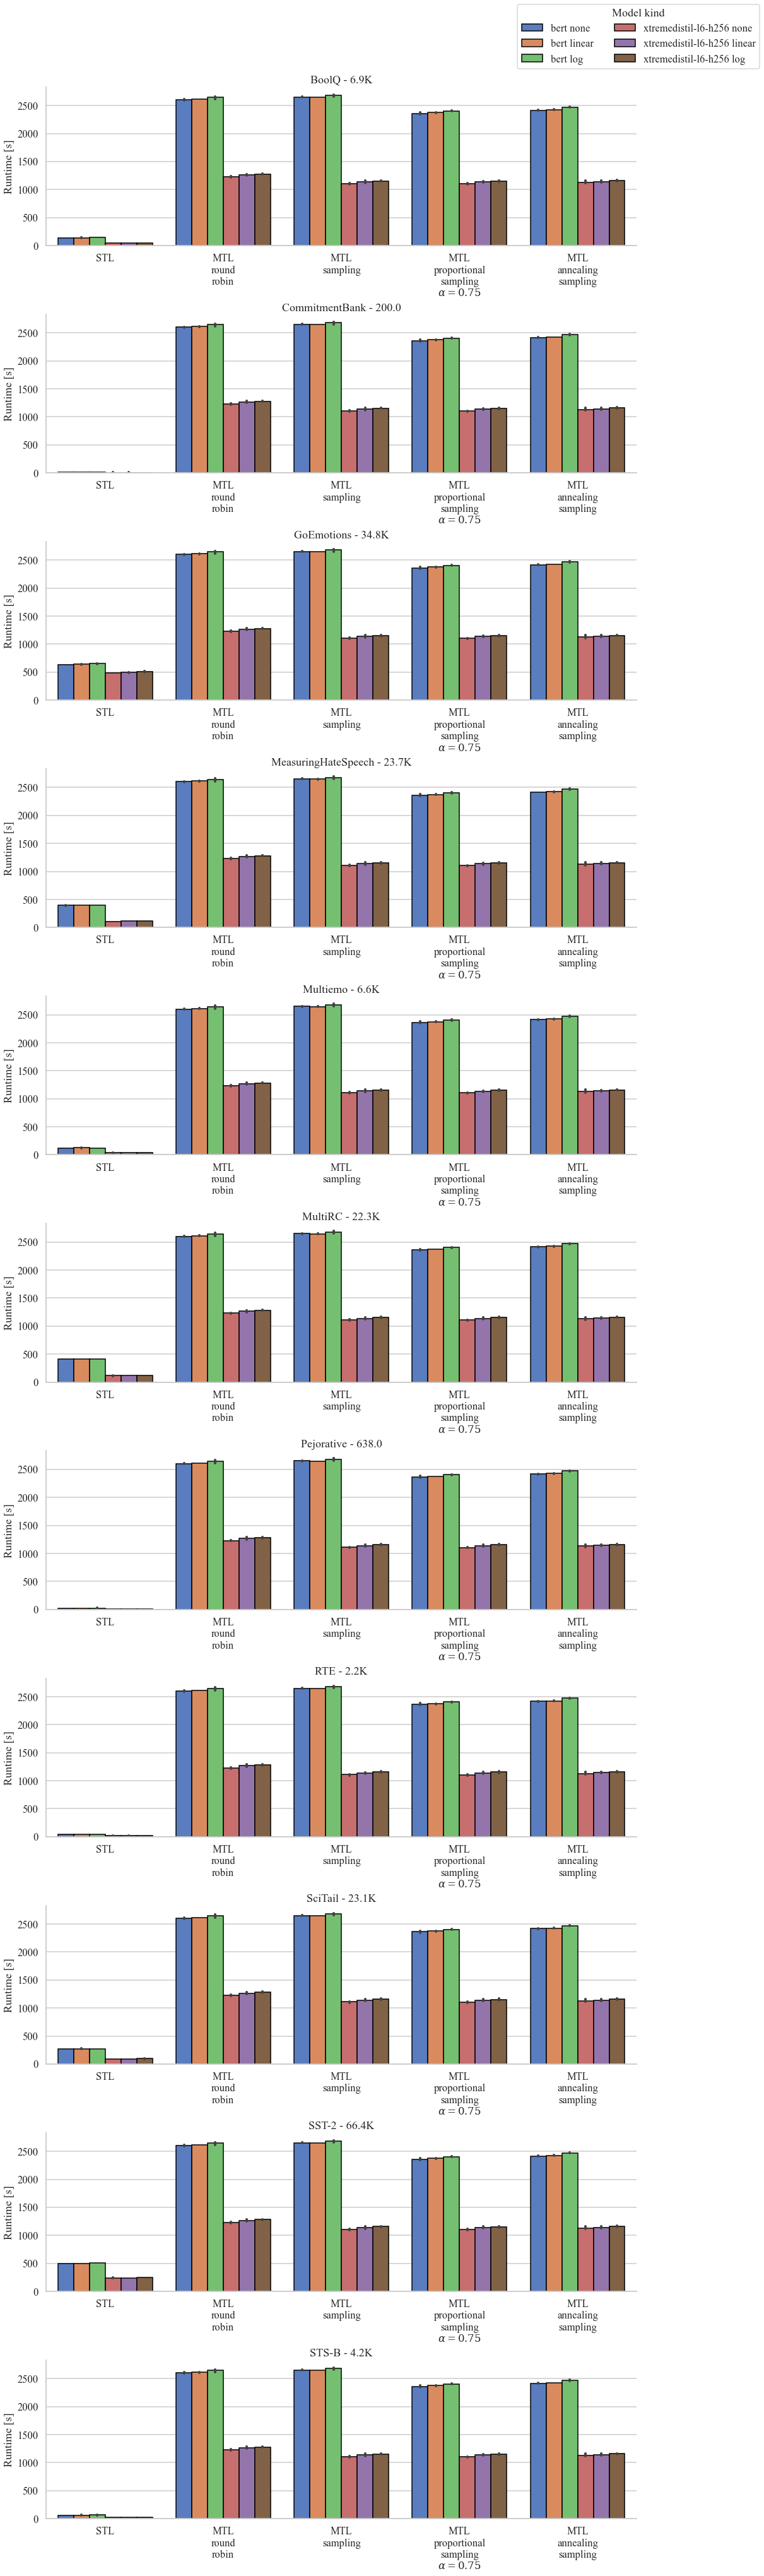

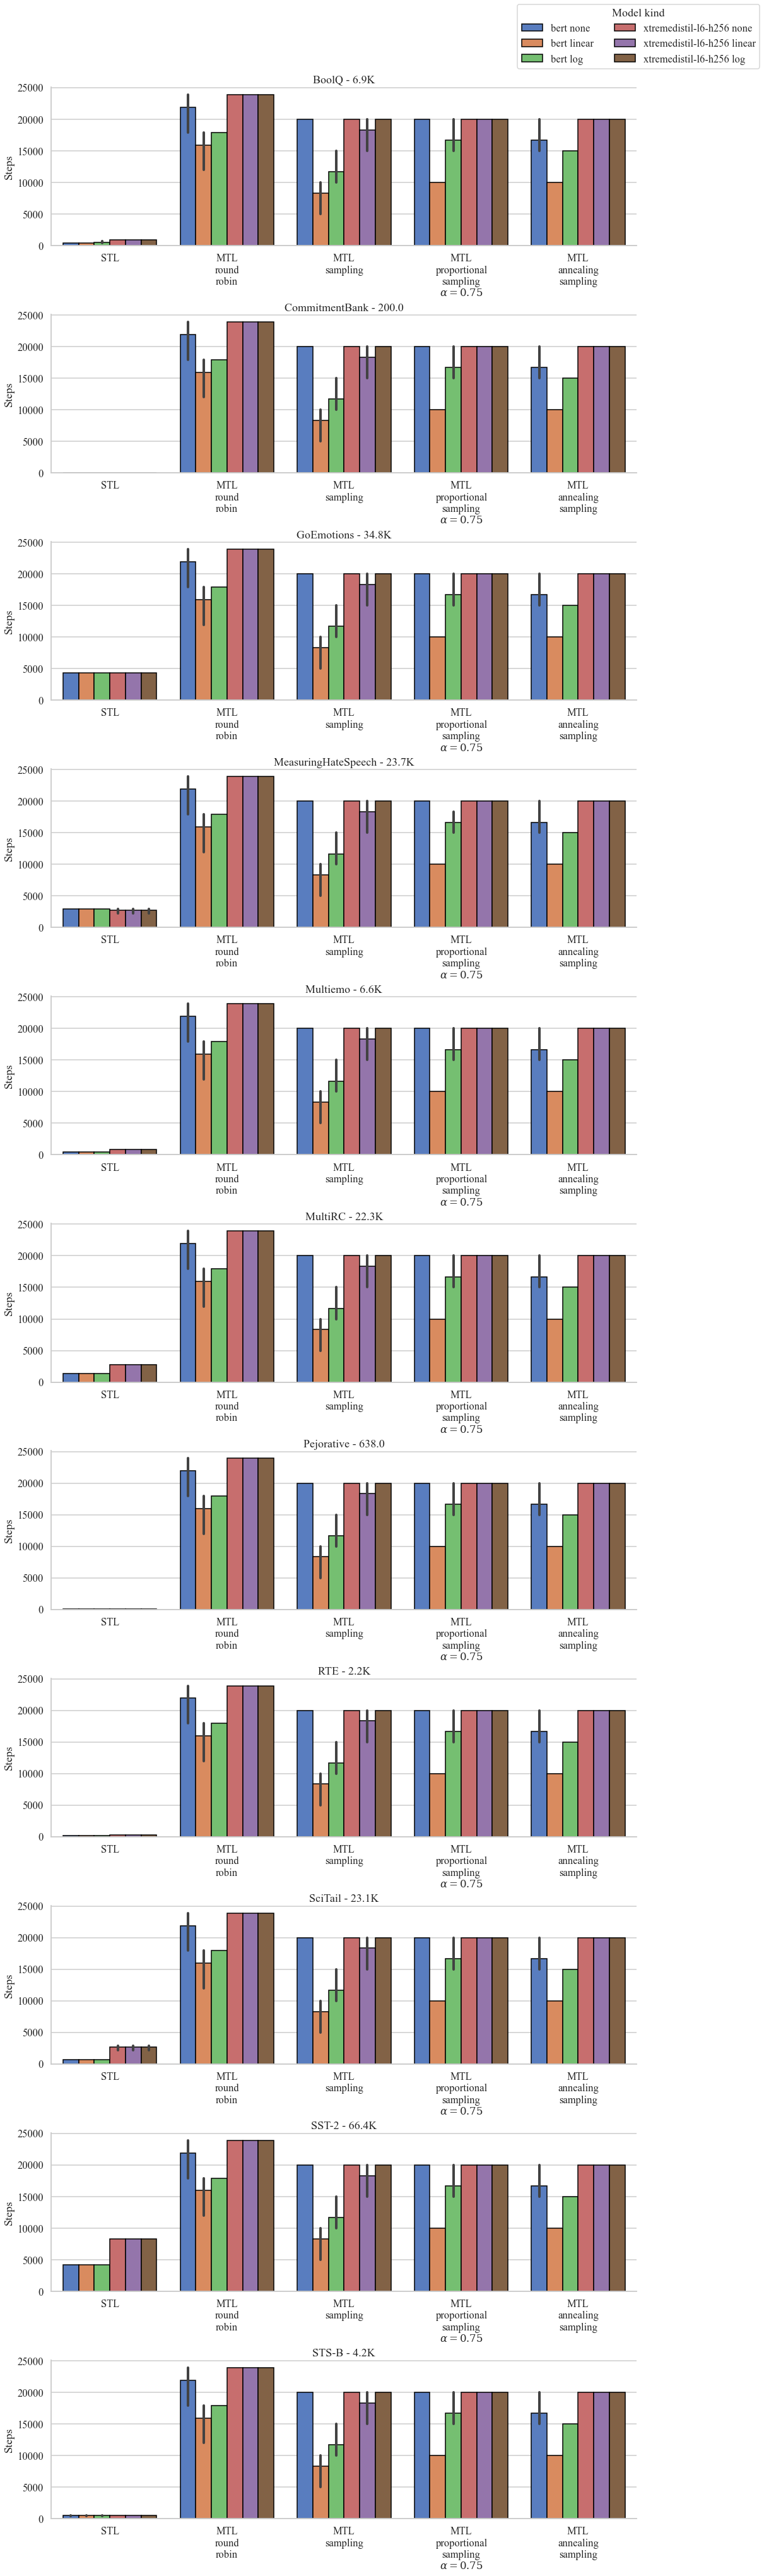

In [17]:
order = ['STL', 'MTL_round_robin', 'MTL_sampling', 'MTL_proportional_sampling_$\\alpha=0.75$', 
         'MTL_annealing_sampling']

hue_order=['bert none', 'bert linear', 'bert log', 'xtremedistil-l6-h256 none',
           'xtremedistil-l6-h256 linear', 'xtremedistil-l6-h256 log']

visualize_boxplot(
    df, tasks=tasks,
    cols=1,
    loc='lower center', showfliers=True, linewidth=1.2, order=order, ncol=2,
    hue='model_kind', 
    hue_order=hue_order,
    runtimes=True, steps=True, only_fig_legend=True
)